# API Data Report - Popularity & Key Signatures
### Anthony Furiga
##### October 11th, 2024

For my API data report, I will be pulling songs from two albums and seeing the comparison the popularity of those tracks (How many plays they have) as it relates to that song's key signature. The two albums I will be using are Taylor Swift's "Lover" album, and Nirvana's "Nevermind" album.  My hypothesis is that songs in those albums that are in key signatures that less flats/sharps in their key signatures (C,F,G,D major for example) will have more listens than songs that are not.  Key signatures on Spotify are listed as numerical values starting at C with 0, and then counting up until it reaches B flat at 11. To make easier, I think songs that have key signature values of 0,2,5,7 and 10 will be more popular than songs that are not those values if they are major, and 2, 5, 7, 9, 11 if they are minor.

The response objects I will be using are the get track's audio features  

In [8]:
import json
import pandas as pd
import requests
import urllib
import base64
import sqlite3

In [9]:
def get_session_token(SessionID, SessionKey):
    url = 'https://accounts.spotify.com/api/token'
    data = {'grant_type':'client_credentials'}
    encoded_key = base64.b64encode(str(SessionID + ":" + SessionKey).encode("ascii"))
    header = {'Authorization': 'Basic {}'.format(encoded_key.decode("ascii"))}
    response = requests.post(url, data = data, headers = header)
    print(response.status_code)
    return response.json()['access_token']

This function will allow me to get my session token from Spotify's API website.

In [10]:
keys = pd.read_csv("Spotify.txt")
access_token = get_session_token(keys['Client_ID'].iloc[0], keys['Client_Secret'].iloc[0])

200


The 200 response indicates that my key into Spotify's API website is working.

In [11]:
t_features_ep = 'https://api.spotify.com/v1/audio-features'
tracks_ep = 'https://api.spotify.com/v1/tracks'
ab_tracks_ep = 'https://api.spotify.com/v1/albums/{}/tracks'

In [12]:
def api_call(endpoint_url, api_header):
    response = requests.get(endpoint_url,headers = api_header)
    print(response.status_code)
    return response.json()

In [13]:
session_header = {'Authorization': 'Bearer {}'.format(access_token)}

In [14]:
ts_album_id = '1NAmidJlEaVgA3MpcPFYGq'
nv_album_id = '2guirTSEqLizK7j9i1MTTZ'

In [15]:
ts_album_response = api_call(ab_tracks_ep.format(ts_album_id), session_header)
nv_album_response = api_call(ab_tracks_ep.format(nv_album_id), session_header)

200
200


The 200 response indicates that I was able to call the two albums from Spotify.

In [16]:
ts_album_df = pd.DataFrame(ts_album_response['items'])
nv_album_df = pd.DataFrame(nv_album_response['items'])

While not shown, this code creates a pandas data frame of the items object for the Taylor Swift and Nirvana albums.

In [17]:
ts_track_ids = ','.join(ts_album_df['id'].to_list())
nv_track_ids = ','.join(nv_album_df['id'].to_list())

This creates a variable with a list of the TrackIDs of the two ablums

In [18]:
t_features_ep + '?ids={}'.format(ts_track_ids)

'https://api.spotify.com/v1/audio-features?ids=43rA71bccXFGD4C8GOpIlN,1BxfuPKGuaTgP7aM0Bbdwr,1dGr1c8CrMLDpV6mPbImSI,3RauEVgRgj1IuWdJ9fDs70,3pHkh7d0lzM2AldUtz2x37,2YWtcWi3a83pdEg3Gif4Pd,214nt20w5wOxJnY462klLw,4y5bvROuBDPr5fuwXbIBZR,12M5uqx0ZuwkpLp5rJim1a,2dgFqt3w9xIQRjhPtwNk3D,1LLXZFeAHK9R4xUramtUKw,4AYtqFyFbX0Xkc2wtcygTr,5hQSXkFgbxjZo9uCwd11so,6RRNNciQGZEXnqk8SQ9yv5,1SymEzIT3H8UZfibCs3TYi,2Rk4JlNc2TPmZe2af99d45,1SmiQ65iSAbPto6gPFlBYm,1fzAuUVbzlhZ1lJAx9PtY6'

In [19]:
ts_track_features = api_call(t_features_ep + '?ids={}'.format(ts_track_ids), session_header)
nv_track_features = api_call(t_features_ep + '?ids={}'.format(nv_track_ids), session_header)

200
200


In [20]:
ts_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(ts_track_ids), session_header)
nv_track_info = api_call(tracks_ep + '?market=US&ids={}'.format(nv_track_ids), session_header)

200
200


These 200 responses mean the code was able to get the information of track_features and track_info from Spotify.

In [21]:
ts_features_df = pd.DataFrame(ts_track_features['audio_features'])
nv_features_df = pd.DataFrame(nv_track_features['audio_features'])

In [22]:
ts_tracks_df = pd.DataFrame(ts_track_info['tracks'])
nv_tracks_df = pd.DataFrame(nv_track_info['tracks'])

In [23]:
ts_merged = pd.merge(ts_features_df, ts_tracks_df, how = 'inner', on = 'id')
nv_merged = pd.merge(nv_features_df, nv_tracks_df, how = 'inner', on = 'id')
ts_merged['artist'] = "Taylor Swift"
nv_merged['artist'] = "Nirvana"

In [24]:
artist_compare = pd.concat([ts_merged, nv_merged], axis = 0)
artist_compare[['name', 'artist', 'key', 'mode', 'popularity']]

,name,artist,key,mode,popularity
0,I Forgot That You Existed,Taylor Swift,5,1,68
1,Cruel Summer,Taylor Swift,9,1,89
2,Lover,Taylor Swift,7,1,84
3,The Man,Taylor Swift,0,1,79
4,The Archer,Taylor Swift,0,1,73
5,I Think He Knows,Taylor Swift,0,1,69
6,Miss Americana & The Heartbreak Prince,Taylor Swift,11,0,75
7,Paper Rings,Taylor Swift,9,1,75
8,Cornelia Street,Taylor Swift,0,1,72
9,Death By A Thousand Cuts,Taylor Swift,4,1,70


This data frame lists the track names, artist, key, mode, and popularity of the two albums into a clean data frame.

## Results

Looking at the Data Frame, I would say my hypothesis was partially incorrect.  This is because I would say with the Taylor Swift album, I was correct, but with the Nirvana album, I was inccorect.  The most popular tracks from the Nirvana album did not fit into the key numbers I specified at the beginning, whereas the most popular tracks (aside from the #1 most popular) for the Taylor Swift album fell into these numbers.

Some drawbacks to this analysis:  Taylor Swift & Nirvana play two different genres of music.  It would be wise to use artists/albums that are the same genre of music.  Also, I believe the value of the popularity number of the tracks reflects only the popularity of that day and not all time.  If this is the case, then tracking the popularity of these tracks overtime would give a better visualization of how popluar these tracks are.

# Analysis Report - Popularity & Key Signatures
### Anthony Furiga
##### November 22nd, 2024

This section of my notebook will be taking the information from the API analysis report and furthering my hypothesis with data visualization.  I will be modifying my hypothesis from the first part and I will be looking at how popularity and key signatures influence each other as a whole.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

Importing some extra code to make graphs and run a linear regression model.

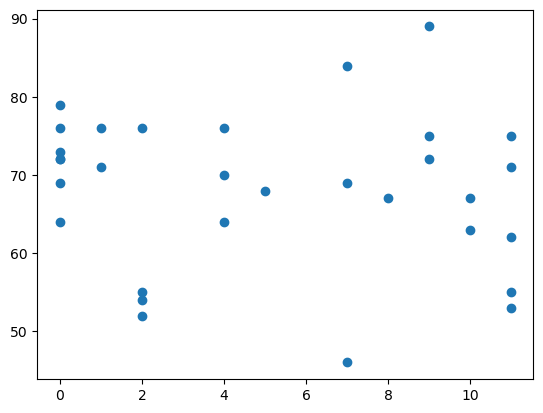

In [28]:
fig1, ax1 = plt.subplots()
ax1.scatter(artist_compare['key'], artist_compare['popularity'])
plt.show()

This scatter plot shows all of the points from the artist_compare data frame.  Visually, there seems to be no coorelation between the popularity value of a song and it's key signature.

In [32]:
fit1 = smf.ols('key ~ popularity', data = artist_compare).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    key   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.4229
Date:                Fri, 22 Nov 2024   Prob (F-statistic):              0.521
Time:                        00:58:41   Log-Likelihood:                -88.190
No. Observations:                  31   AIC:                             180.4
Df Residuals:                      29   BIC:                             183.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6656      5.542      1.564      0.129      -2.669      20.000
popularity    -0.0523      0.080     -0.650      0.521      -0.217       0.112
==============================================================================
Omnibus:                       27.427   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.486
Skew:                           0.141   Prob(JB):                        0.175
Kurtosis:                       1.382   Cond. No.                         494.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To confirm this, I ran a linear regression model that compares the two.  From the results, we get an R-squared value of 0.014, which means there is no coorelation between the two.  The closer the R-squared value is to 1, the more the data suggest the two variables have an influence on each other.

## Results

As suggested by the scatter plot and linear regression model, there seems to be no coorelation at all between Taylor Swift and Nirvanas songs' popularity and their key signature.  I think this is because key signature is just an element in song-creation that really does not have any bearing effect on how well a song will do or not.